In [16]:
from datasets import load_dataset, concatenate_datasets

In [17]:
import numpy as np

def get_stats(data):
    words_num = data.map(lambda x: {"text_words_num": len(x["text"].split()), "summary_words_num": len(x["summary"].split())})
    avg_words_num_text = np.mean(words_num["text_words_num"])
    avg_words_num_summary = np.mean(words_num["summary_words_num"])

    return avg_words_num_text, avg_words_num_summary

In [18]:
data1 = load_dataset("reciTAL/mlsum", 'ru')

full_data1 = concatenate_datasets([
    data1["train"],
    data1["validation"],
    data1["test"]
])
full_data1 = full_data1.remove_columns(['topic', 'url', 'title', 'date'])
print(len(full_data1))

get_stats(full_data1)

27063


(790.2411040904556, 12.775006466393231)

In [19]:
data2 = load_dataset("IlyaGusev/gazeta")

full_data2 = concatenate_datasets([
    data2["train"],
    data2["validation"],
    data2["test"]
])
full_data2 = full_data2.remove_columns(['title', 'date', 'url'])
print(len(full_data2))

get_stats(full_data2)

74126


(628.2115721878963, 42.660550953781396)

In [20]:
data3 = load_dataset("csebuetnlp/xlsum", "russian")

full_data3 = concatenate_datasets([
    data3["train"],
    data3["test"],
    data3["validation"]
])
full_data3 = full_data3.remove_columns(['id', 'url', 'title'])
print(len(full_data3))

get_stats(full_data3)

77803


(547.6641132090023, 25.173039600015425)

In [21]:
data4 = load_dataset("GEM/wiki_lingua", "ru")

full_data4 = concatenate_datasets([
    data4["train"],
    data4["validation"],
    data4["test"]
])
full_data4 = full_data4.remove_columns(['gem_id', 'gem_parent_id', 'source_language', 'target_language', 'references'])
full_data4 = full_data4.rename_columns({"source": "text", "target": "summary"})
print(len(full_data4))

get_stats(full_data4)

50259


(321.91860164348674, 27.94172188065819)

In [24]:
combined_data = concatenate_datasets([full_data1, full_data2, full_data3, full_data4])
combined_data.save_to_disk("combined_data")

Saving the dataset (0/4 shards):   0%|          | 0/229251 [00:00<?, ? examples/s]

In [37]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("ai-forever/FRED-T5-large")

MAX_INPUT_LENGTH = 1024
MAX_TARGET_LENGTH = 300
TASK_PROMPT = "<LM> Сократи текст: "

def is_short_enough(example):
    text_tokens = tokenizer(
        TASK_PROMPT + example["text"],
        truncation=False,
    )["input_ids"]

    summary_tokens = tokenizer(
        example["summary"],
        truncation=False,
    )["input_ids"]

    return len(text_tokens) < MAX_INPUT_LENGTH and len(summary_tokens) < MAX_TARGET_LENGTH

def count_truncations(example):
    input_tokens = tokenizer(TASK_PROMPT + example["text"])["input_ids"]
    target_tokens = tokenizer(example["summary"])["input_ids"]
    return {
        "input_truncated": len(input_tokens) > MAX_INPUT_LENGTH,
        "target_truncated": len(target_tokens) > MAX_TARGET_LENGTH
    }

# input_trunc_count = sum(truncation_stats["input_truncated"])
# target_trunc_count = sum(truncation_stats["target_truncated"])

# TEST

In [23]:
from datasets import load_dataset

raw = load_dataset("RussianNLP/Mixed-Summarization-Dataset")
raw = raw['test']

In [ ]:
import pandas as pd

test = pd.read_csv("test_hand_instruct.csv", sep="|")

In [47]:
test["text"].apply(lambda x: len(tokenizer(x, truncation=False)["input_ids"])).describe()

count     258.000000
mean      391.155039
std       530.653572
min        31.000000
25%       195.500000
50%       297.000000
75%       435.250000
max      6536.000000
Name: text, dtype: float64

In [48]:
test["summary"].apply(lambda x: len(tokenizer(x, truncation=False)["input_ids"])).describe()

count     258.000000
mean      145.341085
std       189.769530
min        20.000000
25%        92.000000
50%       116.500000
75%       157.000000
max      2810.000000
Name: summary, dtype: float64

In [78]:
from datasets import Dataset

filtered_test = Dataset.from_pandas(test).filter(is_short_enough)

def remove_instruction(example):
    text = example['text']
    return {'text': text.split('\n', 1)[-1].strip()[1:-1]}
filtered_test = filtered_test.map(remove_instruction)

Filter:   0%|          | 0/258 [00:00<?, ? examples/s]

Map:   0%|          | 0/247 [00:00<?, ? examples/s]

In [81]:
filtered_test.save_to_disk('filtered_test')

Saving the dataset (0/1 shards):   0%|          | 0/247 [00:00<?, ? examples/s]

# TRAIN

In [ ]:
# from datasets import load_from_disk

# train = load_from_disk('combined_data')
# train_filtered = train.filter(is_short_enough, num_proc=16)

Filter (num_proc=16):   0%|          | 0/229251 [00:00<?, ? examples/s]

In [ ]:
# def count(example):
#     input_tokens = tokenizer(TASK_PROMPT + example["text"])["input_ids"]
#     target_tokens = tokenizer(example["summary"])["input_ids"]
#     source_words = len(example["text"].split())
#     target_words = len(example["summary"].split())
#     return {
#         "input_tokens": len(input_tokens),
#         "target_tokens": len(target_tokens),
#         "source_words": source_words,
#         "target_words": target_words,
#     }
# data_stats = train_filtered.map(count, num_proc=16)

Map (num_proc=16):   0%|          | 0/173138 [00:00<?, ? examples/s]

In [ ]:
# import evaluate
# bertscore = evaluate.load("bertscore")

# def compute_bertscore_batch(batch):
#     results = bertscore.compute(predictions=batch["summary"],
#                                 references=batch["text"],
#                                 lang="ru", device="cuda:0", batch_size=126)
#     return {"bertscore_f1": results["f1"], "bertscore_precision": results["precision"], "bertscore_recall": results["recall"]}
# scored_dataset = train_filtered.map(compute_bertscore_batch, batched=True, batch_size=256)

In [ ]:
# import pandas as pd

# df1 = pd.read_csv("bertscore40000.csv")
# df2 = pd.read_csv("bertscore80000.csv")
# df3 = pd.read_csv("bertscore120000.csv")
# df4 = pd.read_csv("bertscore173138.csv")

# df_ = pd.concat([df1, df2, df3, df4], ignore_index=True)
# df_.drop(columns=["Unnamed: 0", 'text', 'summary'], inplace=True)

# df = pd.concat([pd.DataFrame(data_stats), df_], axis=1)
# df.to_csv("data_stats.csv")

In [17]:
import pandas as pd

df = pd.read_csv("data_stats.csv")

In [2]:
df.shape

(173138, 9)

In [6]:
dupes = df[df.duplicated('text', keep=False)].sort_values('text')
# SEARCH FOR DUPLICATES
for text, group in dupes.groupby('text'):
    print(f"\n--- TEXT ---\n{text[:300]}")
    print("--- SUMMARIES ---")
    for _, row in group.iterrows():
        print(f"- {row['bertscore_f1']:.4f} {row['summary']}")


In [18]:
df = (
    df.assign(summary_length=lambda d: d['target_words'])
      .sort_values(by=['text', 'summary_length'], ascending=[True, False])
      .drop_duplicates(subset='text', keep='first')
      .drop(columns=['summary_length'])
)

In [19]:
df = (
    df.assign(text_length=lambda d: d['source_words'])
      .sort_values(by=['summary', 'text_length'], ascending=[True, False])
      .drop_duplicates(subset='summary', keep='first')
      .drop(columns=['text_length'])
)

In [20]:
df.sort_index(inplace=True)

In [21]:
from datasets import Dataset
from langdetect import detect

dataset = Dataset.from_pandas(df)
dataset = dataset.map(lambda x: {"lang": detect(x["text"])}, num_proc=16)

Map (num_proc=16):   0%|          | 0/171329 [00:00<?, ? examples/s]

In [22]:
df = dataset.to_pandas()

In [23]:
df = df.reset_index()
df.drop(columns=["__index_level_0__"], inplace=True)

In [24]:
df['compression_ratio_words'] = df['source_words'] / df['target_words']

In [25]:
df.to_csv("dedup_data.csv", index=False)

<Axes: >

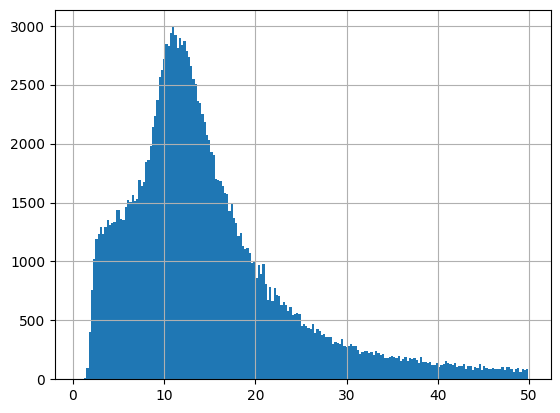

In [26]:
df[df["compression_ratio_words"]< 50]["compression_ratio_words"].hist(bins=200)

<Axes: >

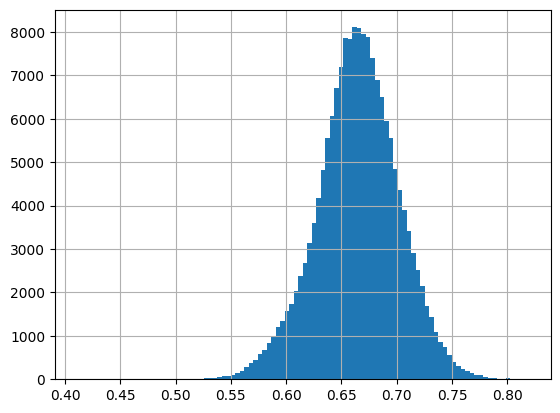

In [28]:
df['bertscore_f1'].hist(bins=100)

<Axes: >

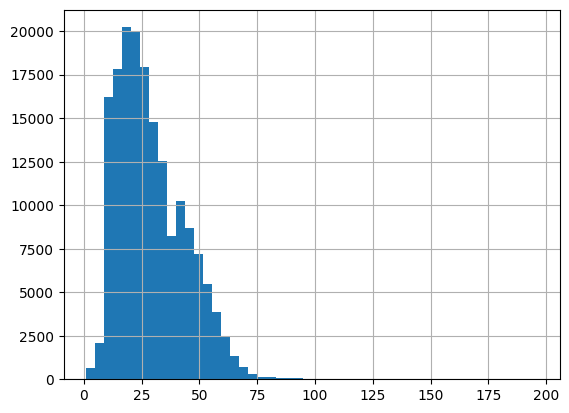

In [49]:
df['target_words'].hist(bins=50)

In [41]:
df1 = df[(df["bertscore_f1"] > 0.65) & (10 < df["compression_ratio_words"]) & (df["compression_ratio_words"] < 30) & (df["target_words"] >= 10) & (df["lang"] == "ru")]
df1.shape

(69686, 12)

<Axes: >

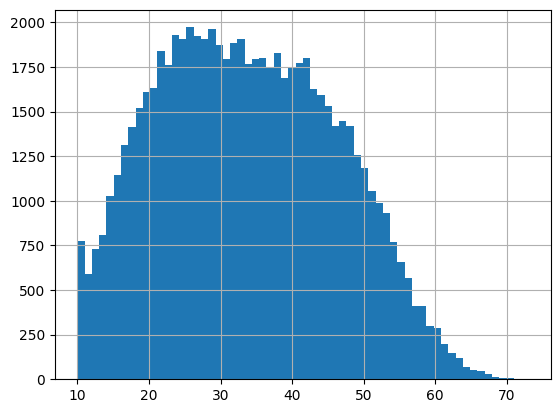

In [47]:
df1['target_words'].hist(bins=62)

<Axes: >

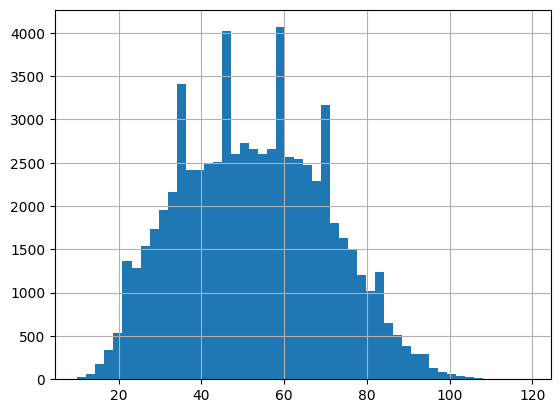

In [53]:
df1['target_tokens'].hist(bins=50)

In [50]:
df1.to_csv("filtered_dedup_data.csv", index=False)

In [52]:
for i in df[(df["bertscore_f1"] > 0.65) & (df["compression_ratio_words"] < 20) & (df["lang"] == "ru") & (df["target_words"] < 10)].sample(1).iterrows():
    print(i[1]["source_words"], i[1]["text"])
    print(i[1]["target_words"], i[1]["summary"])
    print(i[1]["compression_ratio_words"])

59 Симптомы некоторых заболеваний, таких как экзема и псориаз, могут усугубляться от мыла и шампуней. В таких случаях используются шампуни, не содержащие мыла.  Многие считают, что шампунь способствует чрезмерной выработке кожного сала, в то время как шампунь, не содержащий мыльной основы, останавливает этот процесс. Это миф. Существует генетическая предрасположенность к выработке масла, которая совершенно не зависит от используемого вами шампуня.
7 Решите, необходим ли вам шампунь без мыла.
8.428571428571429


In [54]:
from datasets import Dataset 

Dataset.from_pandas(df1).save_to_disk("filtered_dedup_data")

Saving the dataset (0/1 shards):   0%|          | 0/69686 [00:00<?, ? examples/s]

# Synthetic Summ

In [ ]:
# import pandas as pd
# import json
# with open('gpt/train_data.json', 'r') as fin:
#     articles = [json.loads(s) for s in fin.readlines()]

# df = pd.DataFrame(articles)

# df["input_len"] = df["input_ids"].apply(lambda x: len(x))
# print(df["input_len"].describe())
# df["input_len"].hist(bins=50)

# df['words'] = df['Text'].apply(lambda x: len(x.split()))
# df["input_len"] = df["Text"].apply(lambda x: len(tokenizer(x)["input_ids"]))
# df["input_len"].describe()

# SEAHORSE

In [ ]:
from datasets import load_dataset, concatenate_datasets
seahorse = load_dataset("hgissbkh/seahorse")

In [ ]:
seahorse

In [ ]:
QUESTION = "conciseness"
LANGUAGES = ["ru", "en"]


def filter_data(example):
    if(example[QUESTION] == 0.5):
        return False

    example[QUESTION] = int(example[QUESTION])
    return example['lang'] in LANGUAGES #and len(example['summary']) > 15

seahorse_f = seahorse.filter(filter_data)

In [ ]:
full = concatenate_datasets([seahorse_f["train"], seahorse_f["validation"], seahorse_f["test"]])

In [ ]:
# full = full.map(lambda x: {"len": len(tokenizer(x["summary"])["input_ids"])})

# import pandas as pd 

# df = pd.DataFrame(full)

# print(df["len"].describe())

# df["len"].hist(bins=20)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruT5-base")
FORMAT = "тест:\n {} саммари:\n {}"

def preprocess(examples):
    inputs = [FORMAT.format(article, summary)
              for article, summary in zip(examples['text'], examples['summary'])]
    tokenized = tokenizer(inputs, truncation=False)["input_ids"]
    return {"input_ids": tokenized}


seahorse_f = seahorse_f.map(preprocess, batched=True, num_proc=16)

In [ ]:
full = concatenate_datasets([seahorse_f["train"], seahorse_f["validation"], seahorse_f["test"]])

In [ ]:
import pandas as pd

df = pd.DataFrame(full)

In [ ]:
df['sum_len'] = df['summary'].apply(len)

In [ ]:
df['sum_len'].describe()

In [ ]:
from nltk.tokenize import word_tokenize
df['sum_words'] = df['summary'].apply(lambda x: len([token for token in word_tokenize(x) if token.isalpha()]))

In [ ]:
df['sum_words'].describe()

In [ ]:
df[df.duplicated(["text", "summary"], keep=False)].sort_values("summary")

In [ ]:
print(df[QUESTION].value_counts())
df[QUESTION].value_counts().plot(kind='bar')